After submitting admissions the students were awarded with some amount of money, depending on the `Univeraity Rating` and `Chance of Admit`.

$$ \textrm{Award} = \textrm{Chance of Admit} * \textrm{multiplier}_{\textrm{University Rating}}$$

However some information has been lost:
- `Chance of Admit` for each student
- Multipliers

Fortunatelly we have information about the award amounts (`Award`) and students data (`GRE Score`, `TOEFL Score`, `University Rating`, `SOP`, `LOR`, `CGPA`, `Research`, `Chance of Admit`) from admissions.

Build a Bayesian model (possibly linear) for predicting `Chance of Admit` and use in a model that predicts `Award` and train them simultanously using `x_train` and `y_train_award`.

Evaluate the obtained models on:
- `x_test` and `y_test_award` with the stacked model
- `x_test` and `y_test_chance` with the "internal" model

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
import pyro.distributions as dist
from torch import nn
import torch
from torch.distributions import constraints
from pyro.optim import SGD, Adam
from matplotlib import pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\Wilk-PC\Anaconda3\envs\lab\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('./')

In [3]:
from src.utils import run_svi, SviPredictive, summary
from src.visualization import plot_predictions

In [4]:
with open('./data/stacked-regression.pkl', 'rb') as f:
    data = pickle.load(f)
x_train = data['x_train']
y_train_award = data['y_train_award']
y_train_chance = data['y_train_chance']
x_test = data['x_test']
y_test_award = data['y_test_award']
y_test_chance = data['y_test_chance']
print(data['x_train'][0])

tensor([1.1103, 0.6268, 4.0000, 1.1374, 0.5581, 0.7176, 1.0000])


In [14]:
class BayesianLinearRegression(PyroModule):
    def __init__(self, n_input):
        super().__init__()
        self.n_input = n_input
        
    def model(self, x, y=None):
        b_GRE = pyro.sample("b_GRE", dist.Normal(x[:,0], 1))
        b_TEOFL = pyro.sample("b_TEOFL", dist.Normal(x[:,1], 1))
        b_university = pyro.sample("b_university", dist.Normal(x[:,2], 1))
        b_SOP = pyro.sample("b_SOP", dist.Normal(x[:,3], 1))
        b_LOP = pyro.sample("b_LOP", dist.Normal(x[:,4], 1))
        b_CGPA = pyro.sample("b_CGPA", dist.Normal(x[:,5], 1))
        b_research = pyro.sample("b_research", dist.Normal(x[:,6], 1))

        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))

        mean = (
                b_GRE * x[:, 0] +
                b_TEOFL * x[:, 1] +
                b_university * x[:, 2] +
                b_SOP * x[:, 3] +
                b_LOP * x[:, 4] +
                b_CGPA * x[:, 5] +
                b_research * x[:, 6]
        )
        with pyro.plate("data", x.shape[0]):
            return pyro.sample("chance_off_admit-obs", dist.Normal(mean, sigma), obs=y)
            

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):
        # Make sure that guide returns a value
        # guide modeluje posterior (z przymrużeniem oka ;) 
        loc = pyro.param('loc', torch.randn(7))
        scale = pyro.param('scale', torch.ones(7),constraint=constraints.positive)
        
        b_GRE = pyro.sample("b_GRE", dist.Normal(loc[0], scale[0]))
        b_TEOFL = pyro.sample("b_TEOFL", dist.Normal(loc[1], scale[1]))
        b_university = pyro.sample("b_university", dist.Normal(loc[2], scale[2]))
        b_SOP = pyro.sample("b_SOP", dist.Normal(loc[3], scale[3]))
        b_LOP = pyro.sample("b_LOP", dist.Normal(loc[4], scale[4]))
        b_CGPA = pyro.sample("b_CGPA", dist.Normal(loc[5], scale[5]))
        b_research = pyro.sample("b_research", dist.Normal(loc[6], scale[6]))
        
        sigma_mean = pyro.param('sigma_mean',torch.ones(1),constraint=constraints.positive)
        sigma = pyro.sample("sigma", dist.Normal(sigma_mean, torch.Tensor([0.05])))
        
        with pyro.plate("data", x.shape[0]):
            return pyro.sample("chance_off_admit-obs", dist.Normal(sigma_mean, sigma))

    
class StackedModel(nn.Module):
    
    def __init__(self, n_input, initial_multipliers, university_rating_column, university_ratings):
        super().__init__()
        pyro.clear_param_store()
        self.logit = nn.Sigmoid()
        self.linear_regression = BayesianLinearRegression(n_input)
        self.initial_multipliers = initial_multipliers
        self.university_rating_column = university_rating_column
        self.university_ratings = university_ratings
        #self.params_store = pyro.get_param_store()
        
    def model(self, x, y=None):
        chance_off_admit = self.logit(self.linear_regression.forward(x))
        size = len(self.initial_multipliers)
        multi = torch.Tensor(size)
        for key in self.university_ratings:
            multi[key-1]=self.initial_multipliers[key]
            
        multiplier_param = pyro.param('multiplier',multi)
        
        sigma = pyro.sample("Stacked_sigma", dist.Exponential(1.))
        
        mean = torch.empty_like(chance_off_admit)
        for key in self.university_ratings:
            idx = x[:, self.university_rating_column] == key
            mean[idx] = chance_off_admit[idx] * multiplier_param[key-1]
        
        with pyro.plate("stacked-obs",x.shape[0]):
            return pyro.sample(f'award',dist.Normal(mean,sigma),obs=y)
    
    
    
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):
        sigma_param = pyro.param('Stacked_sigma_param',torch.rand(1),constraint=constraints.positive)
        sigma = pyro.sample("Stacked_sigma", dist.Delta(sigma_param))

{'loc': tensor([-0.0277, -0.0136,  0.4929, -0.0761, -0.0999, -0.2365,  0.3997],
       requires_grad=True), 'scale': tensor([0.3097, 0.3070, 0.3107, 0.3080, 0.3212, 0.3316, 0.3376],
       grad_fn=<AddBackward0>), 'sigma_mean': tensor([1.1328], grad_fn=<AddBackward0>), 'Stacked_sigma_param': tensor([2.9312], grad_fn=<AddBackward0>), 'multiplier': tensor([88.0958, 55.7055, 33.9012, 99.1540, 57.9025], requires_grad=True)}


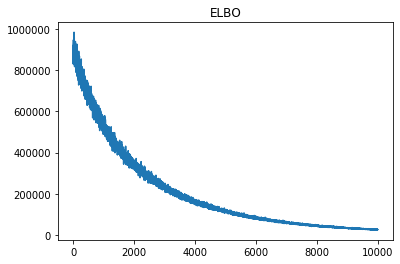

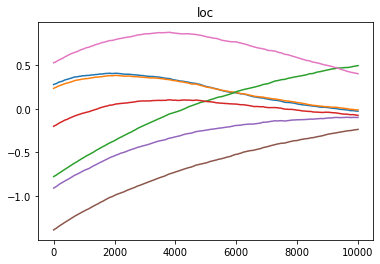

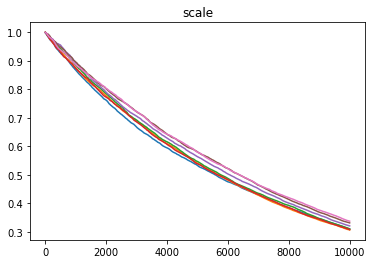

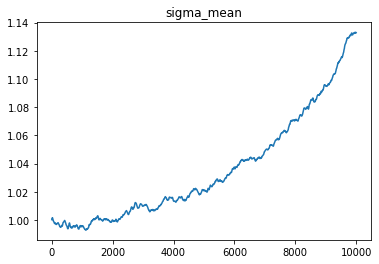

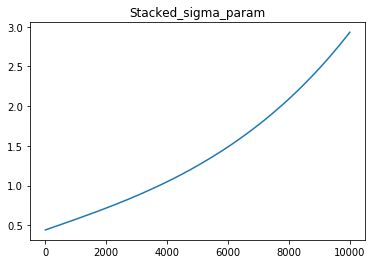

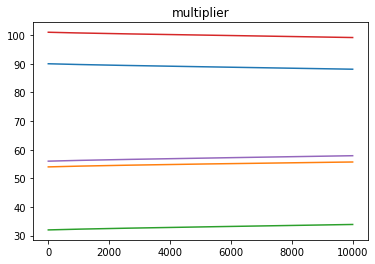

In [10]:
m = StackedModel(
    n_input=7,
    initial_multipliers={
        1: 90,
        2: 54,
        3: 32,
        4: 101,
        5: 56,
    },
    university_rating_column=2,
    university_ratings=range(1,6),
)

elbos, params = run_svi(
    m,
    m.guide,
    x_train,
    y_train_award,
    verbose=True,
    optimizer=Adam({"lr": 0.0003}),
    num_iters=10_000,
    loss=TraceGraph_ELBO()
)
print(dict(pyro.get_param_store()))
plt.plot(elbos)
plt.title('ELBO')
plt.show()

for param in params[0].keys():
    y = [d[param].detach().reshape(-1).numpy() for d in params]
    plt.plot(y)
    plt.title(param)
    plt.show()

# Model evaluation

In [12]:
num_samples = 1_000

## Chance of Admit Model Evaluation

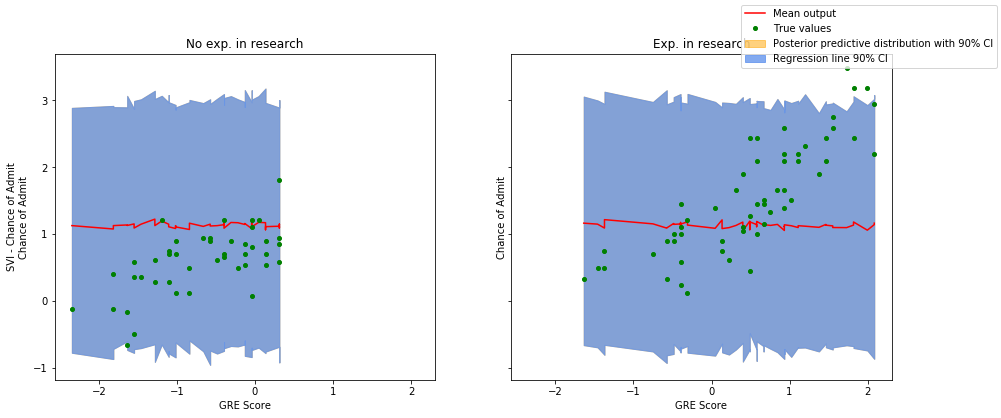

In [13]:
chance_predictive = SviPredictive(
    m.linear_regression.model,
    guide=m.linear_regression.guide,
    num_samples=num_samples,
    return_sites=('chance_off_admit-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Chance of Admit",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Chance of Admit': chance_predictive
}
data = {
    'x': x_test,
    'y': torch.log(y_test_chance / (1 - y_test_chance)) # inverse of nn.Sigmoid()
}
plot_predictions(data, predictors, properties, obs_site_name='chance_off_admit-obs')

## Award Model Evaluation

{'x': tensor([[-0.0418,  0.2976,  3.0000,  0.1273, -0.5235,  0.3038,  0.0000],
        [-0.3963, -1.5129,  1.0000,  0.1273, -0.5235, -0.6561,  1.0000],
        [ 0.4013,  0.2976,  3.0000, -0.3778,  0.5581, -0.6230,  1.0000],
        [ 0.4899, -0.6900,  4.0000, -0.3778, -1.0643, -0.9209,  1.0000],
        [-0.1305, -0.5254,  3.0000, -0.3778, -1.0643, -0.4079,  0.0000],
        [ 0.3127, -1.0191,  2.0000, -0.8828, -0.5235,  0.0721,  0.0000],
        [-0.3077, -0.8545,  3.0000,  0.1273,  0.5581,  0.5355,  1.0000],
        [-1.8143, -1.3483,  2.0000, -0.3778,  0.0173, -2.1457,  0.0000],
        [-1.1053, -0.0316,  3.0000,  0.1273, -0.5235, -1.1858,  0.0000],
        [-0.3963, -0.0316,  3.0000, -0.3778, -0.5235, -0.1927,  1.0000],
        [ 1.8192,  1.7789,  4.0000,  1.1374,  1.0989,  1.7768,  1.0000],
        [-1.4598, -2.0067,  2.0000, -0.3778, -2.1460, -0.5899,  1.0000],
        [ 0.5785,  0.9559,  4.0000,  0.6323,  1.0989,  1.0817,  1.0000],
        [-0.8394, -0.3608,  4.0000, -0.3778, 

KeyError: 'stacked-obs'

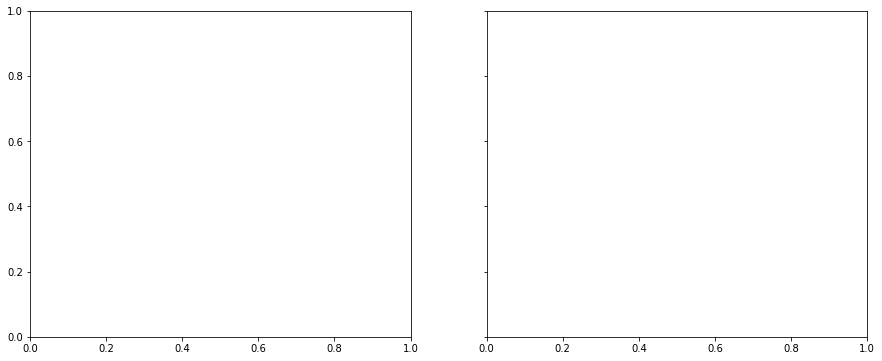

In [13]:
award_predictive = SviPredictive(
    m.model,
    guide=m.guide,
    num_samples=num_samples,
    return_sites=('stacked-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Award",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Award': award_predictive
}
data = {
    'x': x_test,
    'y': y_test_award
}
print(data)
plot_predictions(data, predictors, properties, obs_site_name='stacked-obs')

In [7]:
pyro.clear_param_store()
linear_model = BayesianLinearRegression(n_input=x_train.shape[1])
elbos, params = run_svi(
linear_model,
    linear_model.guide,
    x_train,
    y_train_chance,
    num_iters=1000
)

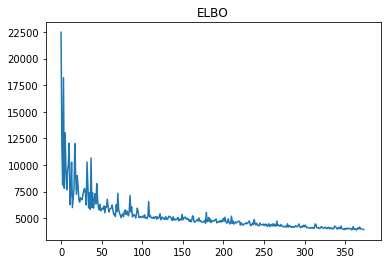

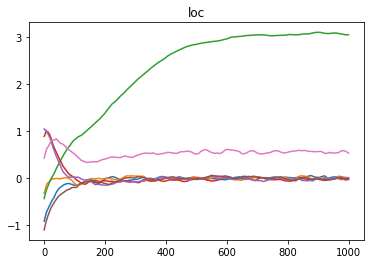

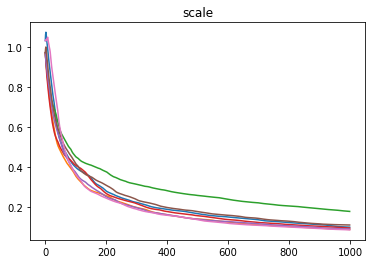

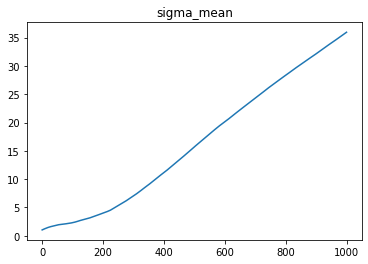

In [8]:

plt.plot(elbos)
plt.title('ELBO')
plt.show()
for param in params[0].keys():
    y = [d[param].detach().reshape(-1).numpy() for d in params]
    plt.plot(y)
    plt.title(param)
    plt.show()

In [9]:
pyro.sample(f"test",dist.Normal(10,20))

tensor(3.0947)